# Deep ensemble for ENSO-forecasting

In this tutorial you learn how to use a neural network model called Deep Ensemble (DE) for the ENSO forecasting. This network architecture was initially developed [Lakshminarayanan et al. (2017)](https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf). 

DEs are feed foreword neural networks that predict the mean and the standard deviation of a Gaussian. Hence, their predicion comes with an uncertainty estimation which is a valuable feature for ENSO-forecasting.

## Create a data pipe line

At first, we define a data pipeline. This is in general quite useful to keep your code clean and also to reuse the pipeline for later purpose.

The data pipeline generates returns:

1. The feature array

2. The label array

3. The time  array corresponding to the time of the label

NOTE (again): Lead time is defined as the time that passed between the last observed and the first date of the target season. Hence, negative appear, e.g. if you compare the DJF season with the target season JFM, you have a lead time of -2 month (Last observed date: Feburary 28/29, First date of the target season January 1).

In [2]:
version = 'undistorted'


In [4]:
from ninolearn.IO.read_processed import data_reader

reader = data_reader(startdate='1951-12', enddate='1993-12', lon_min = 124, lon_max = 280,
                         lat_min = -19, lat_max = 19)

oni = reader.read_csv(('oni_ZC_' +version))
h = reader.read_csv(('h_mean_ZC_' + version))

network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset='ZC_25x25_undistorted', processed="anom")
c2 = network_ssh['fraction_clusters_size_2']
H = network_ssh['corrected_hamming_distance']


In [5]:
if h.shape[0] + c2.shape[0] - H.shape[0] - oni.shape[0] == 0:
    print('All datasets are of equal length')

All datasets are of equal length


In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler

from ninolearn.utils import include_time_lag
from ninolearn.IO.read_processed import data_reader


def pipeline(lead_time):
    """
    Data pipeline for the processing of the data before the Deep Ensemble
    is trained.

    :type lead_time: int
    :param lead_time: The lead time in month.

    :returns: The feature "X" (at observation time), the label "y" (at lead
    time), the target season "timey" (least month)
    """
    reader = data_reader(startdate='1952-01', enddate='1992-12', lon_min = 124, lon_max = 280,
                         lat_min = -19, lat_max = 19)

    # indeces
    oni = reader.read_csv(('oni_ZC_' +version))
    h = reader.read_csv(('h_mean_ZC_' + version))
    #IOD unavailable in ZC87 model 
    
    # seasonal cycle
    sc = np.cos(np.arange(len(oni))/12*2*np.pi)

    # network metrics
    network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset='ZC_25x25_undistorted', processed="anom")
    c2 = network_ssh['fraction_clusters_size_2']
    H = network_ssh['corrected_hamming_distance']

    # time lag
    time_lag = 12

    # shift such that lead time corresponds to the definition of lead time
    shift = 3

    # process features
    feature_unscaled = np.stack((oni, h,
                                 c2, H), axis=1)

    # scale each feature
    scalerX = StandardScaler()
    Xorg = scalerX.fit_transform(feature_unscaled)

    # set nans to 0.
    Xorg = np.nan_to_num(Xorg)

    # arange the feature array
    X = Xorg[:-lead_time-shift,:]
#     X = include_time_lag(X, max_lag=time_lag)
    X = include_time_lag(X, n_lags =12) 


    # arange label
    yorg = oni.values
    y = yorg[lead_time + time_lag + shift:]

    # get the time axis of the label
    timey = oni.index[lead_time + time_lag + shift:]

    return X, y, timey

## Split the data set

For the training and testing of machine learning models it is crucial to split the data set into:

1. __Train data set__ which is used to train the weights of the neural network

2. __Validation data set__ which is used to check for overfitting (e.g. when using early stopping) and to optimize the hyperparameters 

3. __Test data set__ which is used to to evaluate the trained model. 

__NOTE:__ It is important to understand that hyperparamters must be tuned so that the result is best for the Validation data set and __not__ for the test data set. Otherwise you can not rule out the case that the specific hyperparameter setting just works good for the specific test data set but is not generally a good hyperparameter setting.

In the following cell the train and the validation data set are still one data set, because this array will be later splitted into two arrays when th model is fitted.

In [7]:
import keras.backend as K
from ninolearn.learn.models.dem import DEM

# clear memory from previous sessions
K.clear_session()

# define the lead time
lead_time = 12

# get the features (X), the label (y) and 
# the time axis of the label (timey)
X, y, timey = pipeline(lead_time)

# split the data set into 
test_indeces = (timey>='1987-01-01') & (timey<='1993-12-01')
train_val_indeces = np.invert(test_indeces)

train_val_X, train_val_y, train_val_timey = X[train_val_indeces,:], y[train_val_indeces], timey[train_val_indeces]
testX, testy, testtimey = X[test_indeces,:], y[test_indeces], timey[test_indeces]


## Fit the model

Now it is time to train the model! For this a random search is used for all keyword arguments that are passed in a *list* to the DEM.set_parameters() method. 

In [8]:
# initiated an instance of the DEM (Deep Ensemble Model) class
model = DEM()

# Set parameters
model.set_hyperparameters(searchtype='linear', layers=1, neurons=16, dropout=[0.1, 0.5], noise_in=[0.1,0.5], noise_sigma=[0.1,0.5],
                     noise_mu=[0.1,0.5], l1_hidden=[0.0, 0.2], l2_hidden=[0., 0.2],
                     l1_mu=[0.0, 0.2], l2_mu=[0.0, 0.2], l1_sigma=[0.0, 0.2],
                     l2_sigma=[0.0, 0.2], lr=[0.0001,0.01], batch_size=100, epochs=500, n_segments=5,
                     n_members_segment=1, patience=30, verbose=0, pdf='normal', activation = 'relu')

# Use a random search to find the optimal hyperparameters

model.fit_RandomizedSearch(train_val_X, train_val_y, train_val_timey, n_iter=20)

Search iteration Nr 1/20
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
3/3 [==============================] - 0s 13ms/step - loss: 2.7566 - nll_gaussian: 0.9075
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00152: early stopping
3/3 [==============================] - 0s 1ms/step - loss: 2.6832 - nll_gaussian: 0.4719
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00128: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 3.4505 - nll_gaussian: 1.7524
build
Train member Nr 4/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
3/3 [==============================] - 0s 12ms/step - loss: 3.6185 - nll_gaussi

Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 7.5187 - nll_gaussian: 0.5715
build
Train member Nr 4/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 5.4516 - nll_gaussian: 0.5145
build
Train member Nr 5/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 9.2294 - nll_gaussian: 0.8748
Loss: 0.5563071250915528
Computation time: 26.2s
Search iteration Nr 6/20
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 1.0383 - nll_gaussian: 0.3315
build
Train mem

3/3 [==============================] - 0s 7ms/step - loss: 0.4425 - nll_gaussian: 0.0771
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.6884 - nll_gaussian: 0.3747
build
Train member Nr 4/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.4166 - nll_gaussian: 0.0401
build
Train member Nr 5/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.5110 - nll_gaussian: 0.0612
Loss: 0.10337842479348183
Computation time: 30.6s
New best hyperparameters
Mean loss: 0.10337842479348183
{'layers': 1, 'neurons': 16, 'dropout': 0.40127255589946875, 'noise

3/3 [==============================] - 0s 1ms/step - loss: 1.0351 - nll_gaussian: 0.5045
build
Train member Nr 5/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00154: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 1.1500 - nll_gaussian: 0.5124
Loss: 0.5651254177093505
Computation time: 76.5s
Search iteration Nr 17/20
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 1.2919 - nll_gaussian: 0.6836
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 1.5234 - nll_gaussian: 0.7487
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights f

## Make predictions for the test data set
Now we can use the trained models to make predicitons on the test data set to evaluate how good the model perfoms on a data set that it never saw before.

In [9]:
pred_mean, pred_std = model.predict(testX)

## Plot the prediction
Let's see how the predicion is looking like

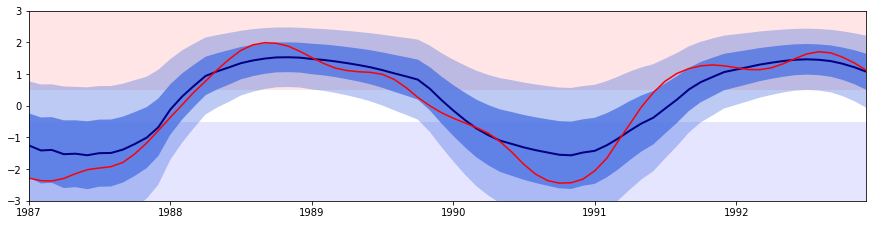

In [10]:
import matplotlib.pyplot as plt
from ninolearn.plot.prediction import plot_prediction
import pandas as pd
from ninolearn.pathes import plotdir

from os.path import join


plt.subplots(figsize=(15,3.5))
plt.axhspan(-0.5,
            -6,
            facecolor='blue',
            alpha=0.1,zorder=0)

plt.axhspan(0.5,
            6,
            facecolor='red',
            alpha=0.1,zorder=0)

plt.xlim(testtimey[0], testtimey[-1])
plt.ylim(-3,3)

# plot the prediction
plot_prediction(testtimey, pred_mean, std=pred_std, facecolor='royalblue', line_color='navy')

# plot the observation
plt.plot(timey, y, "r")

plt.savefig(join(plotdir, f'predicVSobs_{version}_{lead_time}lead'))

plt.show()

## Evaluate the model

We can evaluate the model a bit more quantitatively using the loss function that was used to train the model, namely the negative-log-likelihood of the Gaussian and the correlation between the predicted mean and the observed ONI index.

Loss (Negative-Log-Likelihood): -0.17763477572326233


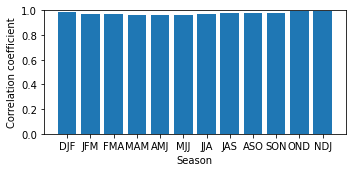

In [11]:
from ninolearn.plot.evaluation import plot_correlation

loss = model.evaluate(testy, pred_mean, pred_std)
print(f"Loss (Negative-Log-Likelihood): {loss}")

# make a plot of the seasonal correaltion
# note: - pd.tseries.offsets.MonthBegin(1) appears to ensure that the correlations are plotted
# agains the correct season
plot_correlation(testy, pred_mean, testtimey - pd.tseries.offsets.MonthBegin(1), title="")

plt.savefig(join(plotdir, f'correlation_{version}_{lead_time}lead'))
